In [67]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Concatenate
from tensorflow.keras import Input, Model
import imageio
%matplotlib widget

In [68]:
import os
image_path = "./data/CameraRGB/"
mask_path = "./data/CameraMask/"
image_list = os.listdir("./data/CameraRGB/")
mask_list = os.listdir("./data/CameraMask/")

In [69]:
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

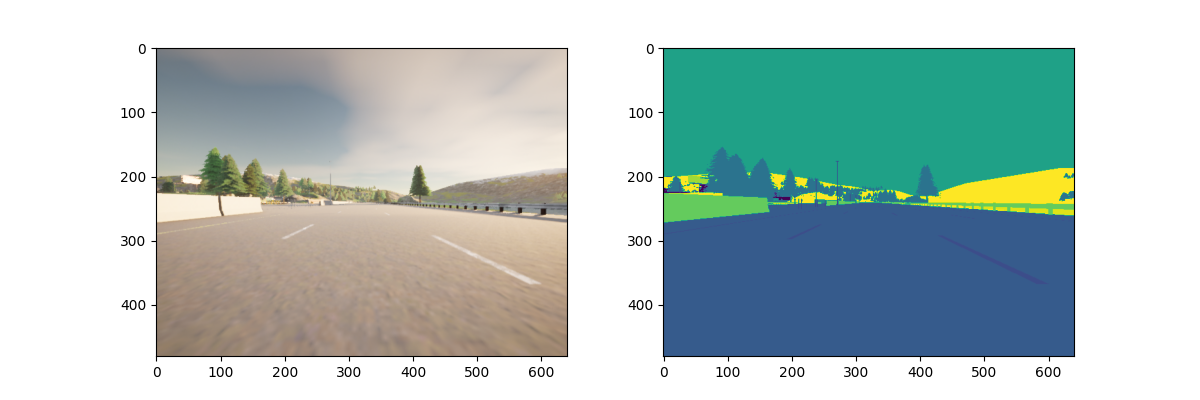

In [70]:
N = 1
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].imshow(imageio.v2.imread(image_list[N]))
axes[1].imshow(imageio.v2.imread(mask_list[N])[:,:, 0])


In [71]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

In [72]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

In [73]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(img, mask):
    input_img = tf.image.resize(img, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')
    return input_img, input_mask

img_ds = dataset.map(process_path)
processed_image_ds = img_ds.map(preprocess)

In [74]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(conv)
    if dropout_prob > 0 :
        conv = Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = MaxPooling2D((2, 2))(conv)
    else:
        next_layer = conv
    return next_layer, conv 

In [75]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    conv_trans = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal')(expansive_input)
    final = Concatenate(axis=3)([conv_trans, contractive_input])
    conv = Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(final)
    conv = Conv2D(n_filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(conv)
    return conv

<img src="./unet.png" style="width:800px;height:800;">

In [76]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    conv_block1 = conv_block(inputs, n_filters)
    conv_block2 = conv_block(conv_block1[0], n_filters*2)
    conv_block3 = conv_block(conv_block2[0], n_filters*4)
    conv_block4 = conv_block(conv_block3[0], n_filters*8, dropout_prob=0.3)
    conv_block5 = conv_block(conv_block4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) #Bottle Neck Block

    upsample_block1 = upsampling_block(conv_block5[0], conv_block4[1], n_filters*8)
    upsample_block2 = upsampling_block(upsample_block1, conv_block3[1], n_filters*4)
    upsample_block3 = upsampling_block(upsample_block2, conv_block2[1], n_filters*2)
    upsample_block4 = upsampling_block(upsample_block3, conv_block1[1], n_filters)
    
    conv_9 = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', activation='relu')(upsample_block4)
    conv_10 = Conv2D(filters=n_classes, padding='same', kernel_size=(1, 1))(conv_9)

    return Model(inputs, conv_10)

In [126]:
96*2

192

In [131]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [132]:
unet.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_142 (Conv2D)            (None, 96, 128, 32)  896         ['input_13[0][0]']               
                                                                                                  
 conv2d_143 (Conv2D)            (None, 96, 128, 32)  9248        ['conv2d_142[0][0]']             
                                                                                                  
 max_pooling2d_31 (MaxPooling2D  (None, 48, 64, 32)  0           ['conv2d_143[0][0]']       

In [133]:
unet.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [134]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 [==============================] - 5s 95ms/step - loss: 1.7245 - accuracy: 0.4536
Epoch 2/40
34/34 [==============================] - 3s 75ms/step - loss: 0.9587 - accuracy: 0.7366
Epoch 3/40
34/34 [==============================] - 3s 75ms/step - loss: 0.6256 - accuracy: 0.8144
Epoch 4/40
34/34 [==============================] - 3s 75ms/step - loss: 0.6263 - accuracy: 0.8313
Epoch 5/40
34/34 [==============================] - 3s 77ms/step - loss: 0.4653 - accuracy: 0.8625
Epoch 6/40
34/34 [==============================] - 3s 77ms/step - loss: 0.3988 - accuracy: 0.8789
Epoch 7/40
34/34 [==============================] - 3s 76ms/step - loss: 0.3583 - accuracy: 0.8898
Epoch 8/40
34/34 [==============================] - 3s 76ms/step - loss: 0.3086 - accuracy: 0.9065
Epoch 9/40
34/34 [==============================] - 3s 76ms/step - loss: 0.3023 - accur

#### Achieved 97.88% Accuracy in 107.6s on a RTX 4060Ti 8G

In [135]:
def create_mask(pred_mask):
    return tf.argmax(pred_mask, axis=-1)

1/1 [==============================] - 0s 33ms/step


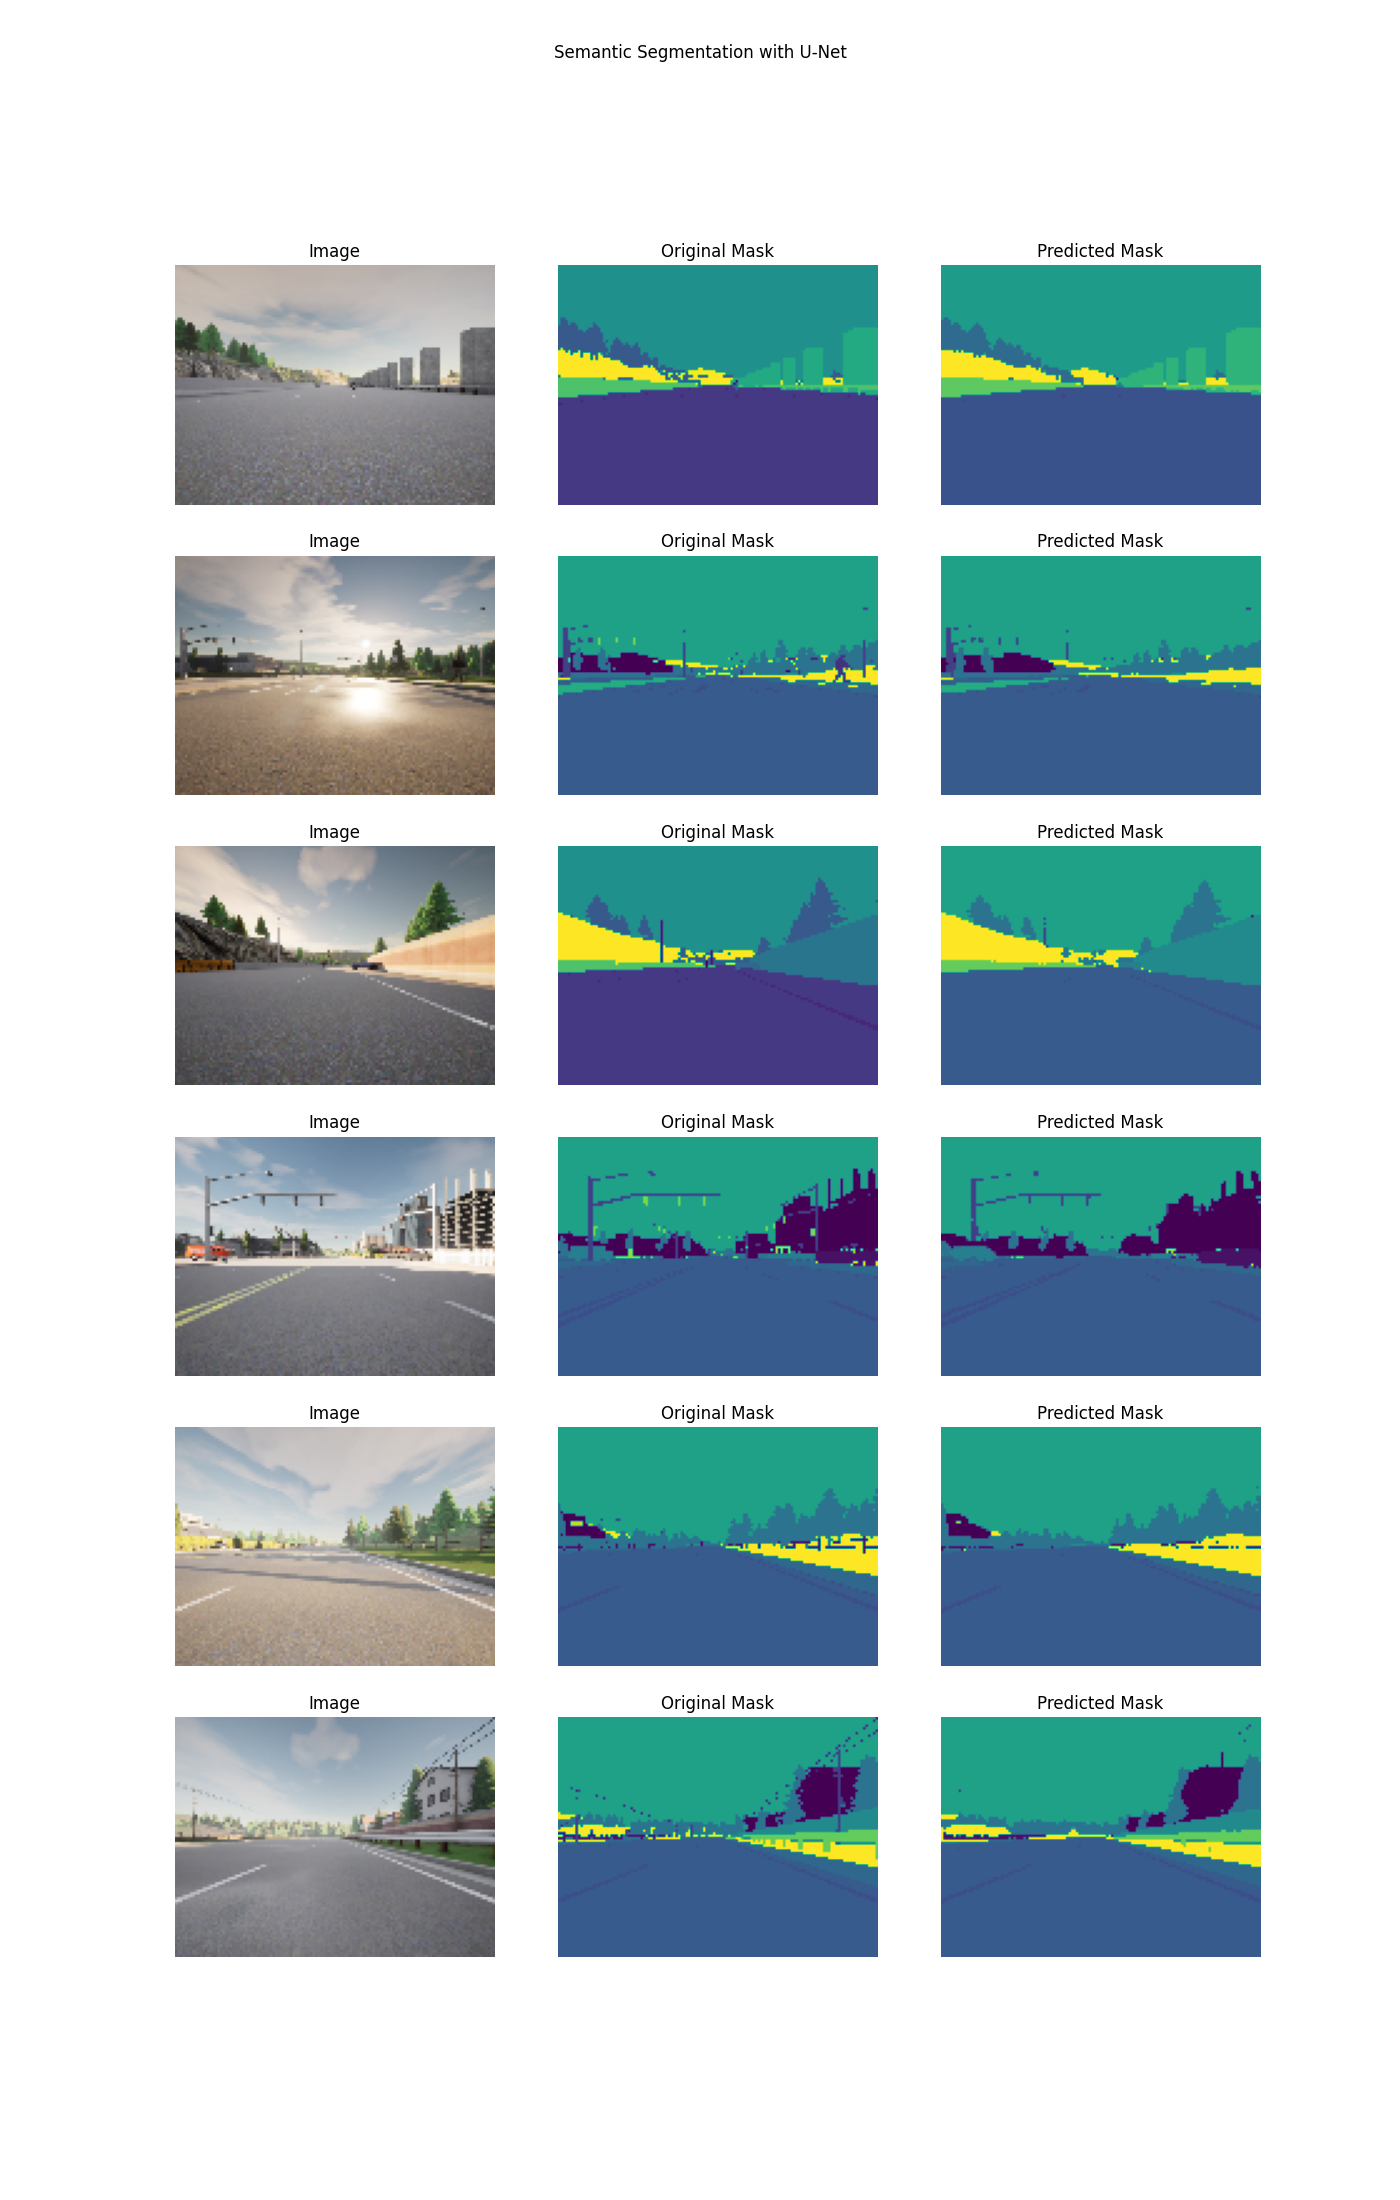

In [141]:
fig, axes = plt.subplots(6, 3, figsize=(14, 22))
fig.suptitle("Semantic Segmentation with U-Net")
for ax in axes.flat:
    ax.axis('off')
for image, mask in train_dataset.take(1):
    pred_mask = unet.predict(image)
    for i in range(6):
        ax = axes[i]
        ax[0].imshow(image[i])
        ax[0].set_title("Image")
        ax[1].imshow(mask[i])
        ax[1].set_title("Original Mask")
        ax[2].imshow(create_mask(pred_mask[i]))
        ax[2].set_title("Predicted Mask")
fig.savefig("./results.jpg", dpi=200)